# Watershed Project - Mapping Floodplain Connectivity in Boulder County
![Watershed Project](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/South_Boulder_Creek_%28Colorado%29.JPG/1920px-South_Boulder_Creek_%28Colorado%29.JPG)

*Img source: 1*

## Collaborators and Acknowledgements
Julia Sobczak, Lindsay Chipman, Matthew Bitters, and the [Watershed Center](https://watershed.center/)

Spring project for the University of Colorado Earth Data Analytics program, [Earth Lab](https://www.earthdatascience.org/)

## Project Description

### Background and Project Goals
A connected, functional floodplain retains water during periods of high flow and releases it back into the stream when flows are low. This process increases the resiliency and biodiversity of floodplain vegetation by providing a higher water table and thus longer, easier access to potentially limiting resources. Deposition by flooding events can increase water quality by 'dropping' harmful heavy metals or high nutrient loads onto the floodplain, keeping them from continuing downstream (2). Unfortunately, due to urban development and agriculture, floodplains can become disconnected from their source river. Reduced connectivity results in greater magnitude of flood events and vulnerability of surrounding ecosystems to drought.  Therefore, understanding connectivity can help guide water resource management and strengthen communities against natural disasters. 

![Disconnected floodplain](https://www.mdpi.com/water/water-12-02762/article_deploy/html/images/water-12-02762-g001-550.jpg)
*Img source: 2*

Through this project, we aim to map floodplain connectivity at 5 target sites in the St. Vrain Basin in Boulder, CO and use the results to evaluate if desired watershed conditions are being met. We will also compare the results between UAV or LiDAR derived data, to see which performs better in terms of quantifying floodplain connectivity. Our aim is to create an open and reproducible workflow for The Watershed Center and other researchers to use for future analysis.

### Methods
We will use two types of data:
* UAV imagery (to process in Agisoft and create DTM), source: DJI Phantom 4, collected by contractor in Spring & Fall 2022
* LiDAR data (downloaded as LAS and DTM), source: [Colorado Hazard Mapping, Airborne Snow Observatories](https://coloradohazardmapping.com/lidarDownload)

For each of these datasets, we will create digital elevation models (DEM), and digital terrain models (DTM; DEM with vegetation removed) for each site using Agisoft Metashape Professional v1.8.5. We will then create relative elevation models for the five DTM's with two different methods: the first of which follows the watershed center's protocol relying on the Colorado Water Conservation Board’s REM Generator Tool in ArcMap, the second uses the RiverREM package to generate a relative elevation model for each site with each data source (UAV and LiDAR)

Elevation models are a core component of modern-day floodplain mapping. High-accuracy DEM's are necessary to sufficiently predict how water will flood an area based on the surface slope and topography (3). Elevation models are digital grids with an elevation value assigned to each square; a low-resolution DEM has fewer and larger squares while a high-resolution DEM has many smaller square. REM's and DTM's (bare earth models) are derivative products from a DEM, so they'll all have the same resolution unless down-sampling occurs. For this reason, it's important to obtain a high-quality DEM before attempting any complex processing tasks in order to accurately predict flooding events and impacts.

![DEM grids](https://ars.els-cdn.com/content/image/1-s2.0-S0016706100000811-gr2.gif)
*Img source: 4*

Our end products include a REM and histogram for each of the 5 sites, created from both UAV- and LiDAR-derived data as well as a qualitative and quantitative comparison between the two data sources to suggest which method is best for The Watershed Center to use for future floodplain mapping. Ultimately, we hope to replicate the existing, software-reliant process using python tools to create an open and reproducible workflow for generating REM's.

### This Notebook
In this notebook, we plot the study sites and generate a preliminary REM using a pre-processed DTM from the Highway 93 site and the REMMaker function. Please ensure the [RiverREM package](https://github.com/OpenTopography/RiverREM) is downloaded on your computer before running the REMMaker tool, see the readme file for download instructions. The DTM was created by processing UAV-derived images in Agisoft (this step was completed by the Watershed Center). We loaded this DTM to a GitHub release to allow the user of this notebook to download it. We also provide a  shapefile of the centerline of the River at the study site, which was genereated in ArcGIS. 

![RiverREM](https://object.cloud.sdsc.edu/v1/AUTH_opentopography/www/docs/REMBlogPost/birch_crop.png)
*Img source: 5*

### Sources
1. Wikimedia Foundation. (2022, September 4). South Boulder creek (Colorado). Wikipedia. https://en.wikipedia.org/wiki/South_Boulder_Creek_(Colorado)
2. Gordon, B.A.; Dorothy, O.; Lenhart, C.F. Nutrient Retention in Ecologically Functional Floodplains: A Review. Water 2020, 12, 2762. https://doi.org/10.3390/w12102762
3. Hawker, L., Bates, P., Neal, J., &amp; Rougier, J. (2018, November 30). Perspectives on Digital Elevation Model (DEM) simulation for flood modeling in the absence of a high-accuracy open access global dem. Frontiers. https://www.frontiersin.org/articles/10.3389/feart.2018.00233/full 
4. Thompson, J. A., Bell, J. C., &amp; Butler, C. A. (2001, February 5). Digital elevation model resolution: Effects on terrain attribute calculation and quantitative soil-landscape modeling. ScienceDirect. https://www.sciencedirect.com/science/article/pii/S0016706100000811 
5. Larrieu, K. (2022). RiverREM (Version 1.0.4) [OpenTopography; GitHub]. https://github.com/OpenTopography/RiverREM

In [1]:
# Import packages
# Make sure you have RiverREM imported, check readme for instructions
import os
import pathlib

import matplotlib.pyplot as plt
from plot_site_map import plot_sites
import requests
from riverrem.REMMaker import REMMaker, clear_osm_cache
import rioxarray as rxr

C:\Users\Julia\miniconda3\envs\earth-analytics-python\lib\site-packages\geopandas\tools\clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [2]:
# Set working directory
working_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'watershed-project')
if not os.path.exists(working_dir):
    print('{} does not exist. Creating...'.format(working_dir))
    os.makedirs(working_dir)

os.chdir(working_dir)

# Study Sites
The study sites are five streams in the St. Vrain Watershed, Boulder County. For this notebook, only data from the Highway 93 site was used.

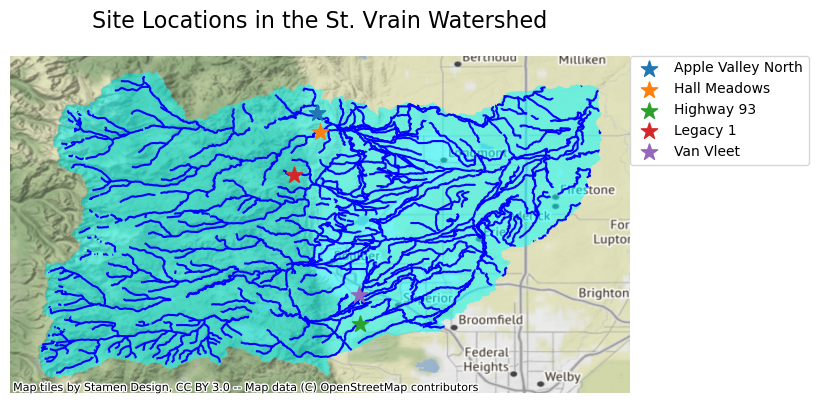

In [3]:
# Plot the study sites - find related code in plot_site_map
plot_sites()

In [4]:
# Define url, directory, and path to DTM
hwy_93_url = ("https://github.com/lechipman/watershed-project/releases"
              "/download/v1.0.0/DTM_Highway93.tif")
dtm_dir = os.path.join('uav_hwy93')
dtm_path = os.path.join(dtm_dir, 'DTM_Highway93.tif')

In [5]:
# Create directory and download DTM file if doesn't exist
override_cache = False
if not os.path.exists(dtm_dir):
    print('{} does not exist. Creating...'.format(dtm_dir))
    os.makedirs(dtm_dir)

if (not os.path.exists(dtm_path)) or override_cache:
    print('{} does not exist. Downloading...'.format(dtm_path))
    # Opem DTM file
    response = requests.get(hwy_93_url)

    # Open a local file with wb permission and write response content
    with open(dtm_path, 'wb') as dtm_file:
        dtm_file.write(response.content)

# Highway 93 DTM (UAV-derived)

Text(0.5, 1.0, 'DTM derived from UAV Imagery')

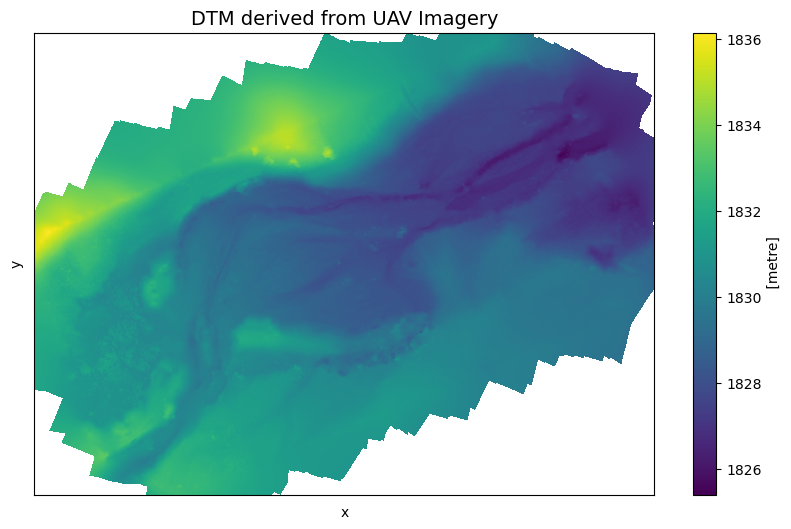

In [6]:
# Open and plot the DTM
dtm = rxr.open_rasterio(dtm_path, masked=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Hide x and y axes labels and ticks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])

# Plot DTM
dtm.coarsen(
    x=3,
    boundary='trim').mean().coarsen(
        y=3,
        boundary='trim').mean().squeeze().plot(
            ax=ax)

# Add title
ax.set_title('DTM derived from UAV Imagery', fontsize=14)

# Run REMMaker tool using DTM as input
RiverREM is a Python package for automatically generating river relative elevation model (REM) visualizations from an input DTM. For this notebook, the tool uses the stream centerline default (taken from the rivers layer in OpenStreetMap), but in future iterations, we will use our own centerline shapefile to input as a parameter. This will allow for better comparison with the Watershed Center's current process which uses the same user-created centerline shapefile in ArcMap.

In [7]:
# Run rem_maker without specified centerline
# Input the DEM file path and desired output directory
rem_maker = REMMaker(dem=dtm_path, out_dir=dtm_dir, interp_pts=1000)

# clear OSM cache
clear_osm_cache()

# create an REM
rem_maker.make_rem()
# create an REM visualization with the given colormap
rem_maker.make_rem_viz(cmap='mako_r')

[INFO] 2023-05-02 23:14:45,463 - Getting DEM projection.
[INFO] 2023-05-02 23:14:45,469 - Reading DEM as array.
[INFO] 2023-05-02 23:14:47,676 - Getting DEM bounds.
[INFO] 2023-05-02 23:14:47,685 - Mapping array indices to coordinates.
[INFO] 2023-05-02 23:14:47,733 - Finding river centerline.


Clearing OSM cache.


C:\Users\Julia\miniconda3\envs\earth-analytics-python\lib\site-packages\geopandas\tools\clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
[INFO] 2023-05-02 23:14:49,052 - Found river(s): Coal Creek
[INFO] 2023-05-02 23:14:49,052 - 
River lengths:
C:\Users\Julia\miniconda3\envs\earth-analytics-python\lib\site-packages\riverrem\REMMaker.py:257: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river_length = river_segments.length.sum()
[INFO] 2023-05-02 23:14:49,965 - 	Coal Creek: 0.0035 degree
[INFO] 2023-05-02 23:14:49,965 - 
Longest river in domain: Coal Creek

[INFO] 2023-05-02 23:14:50,016 - Making river points 


Making multidirectional hillshade raster.
Tiling and compressing raster.
Saved ./.cache\DTM_Highway93_hillshade.tif.

Making color relief map with cmap=mako_r.
Tiling and compressing raster.
Saved ./.cache\DTM_Highway93_REM_color-relief.tif.

Generating .png file.
Saved ./.cache\DTM_Highway93_REM_color-relief.png.

Making hillshade-color composite raster.
Tiling and compressing raster.
Saved uav_hwy93\DTM_Highway93_hillshade-color.tif.

Generating .png file.
Saved uav_hwy93\DTM_Highway93_hillshade-color.png.


'uav_hwy93\\DTM_Highway93_hillshade-color.tif'

# Output Highway 93 REM
We are noticing some streaks in the image, perpendicular to the river channel, which may indicate poor interpolation and needs further investigation.

Text(0.5, 1.0, 'REM derived from UAV Imagery')

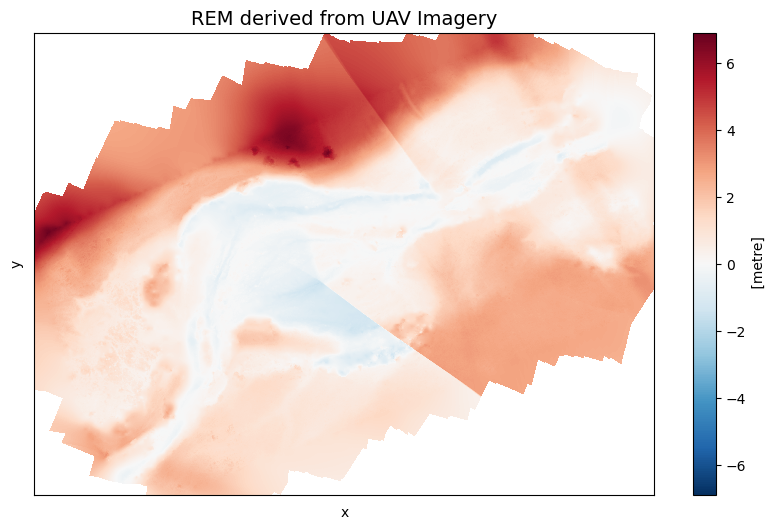

In [8]:
# Open and plot the REM you just generated
rem_path = os.path.join(dtm_dir, 'DTM_Highway93_REM.tif')
rem = rxr.open_rasterio(rem_path, masked=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Hide x and y axes labels and ticks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)
ax.set_xticks([])
ax.set_yticks([])

# Plot REM
rem.coarsen(
    x=3,
    boundary='trim').mean().coarsen(
        y=3,
        boundary='trim').mean().plot(
            ax=ax)

# Add title
ax.set_title('REM derived from UAV Imagery', fontsize=14)

# REM Histogram
The histogram indicates what elevations occur most frequently. A gently sloping curve (away from zero) may indicate better floodplain connectivity.

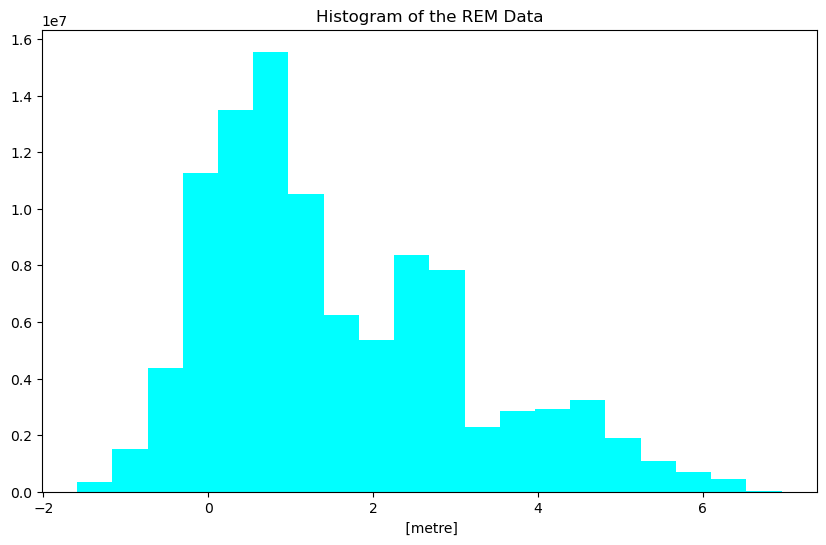

In [9]:
# Create REM histogram plot figure
fig, ax = plt.subplots(figsize=(10, 6))
rem.plot.hist(color="cyan", bins=20)
ax.set_title("Histogram of the REM Data")
plt.show()